In [1]:
import npu
import numpy as np
from npu.build.appbuilder import AppBuilder
from npu.runtime import AppRunner
import pylab as plt
import scipy

In [2]:
M     = 2          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1024       # Number of windows of length M*P in input time stream
n_int = 10          # Number of time integrations on output data
n_points=64
dt=np.float32

In [3]:
%%kernel

void passthrough(float *in_buffer, float *out_buffer, uint32_t nbytes)
{
    for(int i=0; i<nbytes; i++) {
        out_buffer[i] = in_buffer[i];
    }
}

In [4]:
passthrough

In [5]:
passthrough.ports[0].array = np.ndarray([1, M*P], dtype=dt) # uint16_t as placeholder of same size
passthrough.ports[1].array = np.ndarray([1, M*P], dtype=dt)

In [6]:
class SimpleApplication(AppBuilder):
    
    def __init__(self, kernel):
        self.kernel = kernel
        super().__init__()

    def callgraph(self, x_in:np.ndarray, x_out:np.ndarray):
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1]
        for row in range(rows):
            kernel_output = self.kernel(x_in[row], bytes_per_row)
            x_out[row] = kernel_output

In [7]:
app_builder = SimpleApplication(kernel=passthrough)

In [8]:
input_data = np.zeros(shape=(1, M*P), dtype=dt)
output_data = np.zeros(shape=(1, M*P), dtype=dt)

app_builder.build(input_data, output_data)

Building the passthrough kernel...
Building the xclbin...
Successfully Building Application... SimpleApplication.xclbin & SimpleApplication.seq delivered


In [9]:
app_builder.metadata

{'application': 'SimpleApplication',
 'kernels': OrderedDict([('itbuffer_0',
               {'name': 'itbuffer_0',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin': {'c_dtype': None,
                  'direction': 'in',
                  'name': 'ITin',
                  'ctype': None,
                  'shape': (1, 2048),
                  'dtype': 'float32'},
                 'ITout': {'c_dtype': None,
                  'direction': 'out',
                  'name': 'ITout',
                  'ctype': None,
                  'shape': (1, 2048),
                  'dtype': 'float32'}},
                'shape': (1, 2048),
                'dtype': 'float32'}),
              ('itbuffer_1',
               {'name': 'itbuffer_1',
                'tloc': None,
                'ttype': 'IT',
                'ktype': 'buffer',
                'type': 'IT',
                'ports': {'ITin

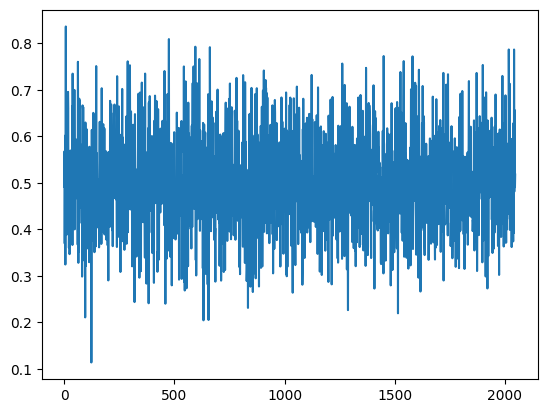

<Figure size 640x480 with 0 Axes>

In [10]:
from npu.utils import OpenCVImageReader, image_plot

samples = np.arange(M*P)
noise   = np.random.normal(loc=0.5, scale=0.1, size=M*P).astype(dt)
freq    = 1
amp     = 1
cw_signal = (amp * np.sin(samples * freq))
data = noise
plt.plot(data)
plt.show()
plt.clf()

In [11]:
print(type(data))
print(data)

<class 'numpy.ndarray'>
[0.49155045 0.5677734  0.3696074  ... 0.65643704 0.490663   0.5178687 ]


In [12]:
app = AppRunner('SimpleApplication.xclbin')

In [13]:
# Allocate app input and output buffers to exchange data with NPU
inputs = app.allocate(shape=(1, M*P), dtype=dt)
outputs = app.allocate(shape=(1, M*P), dtype=dt)

In [14]:
# Load RGBA 720p image into input_image buffer
inputs[:] = data

In [15]:
# Pass input_image buffer to NPU
outputs.sync_to_npu()

In [16]:
# Run app on NPU
app.call(inputs, outputs)

In [17]:
# Get results from NPU via output_image buffer 
outputs.sync_from_npu()

Are the arrays are equal?: False


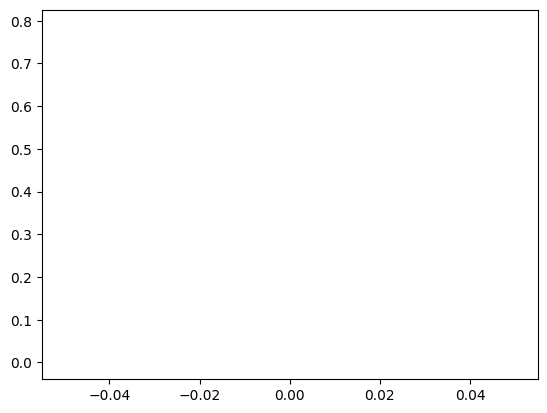

<Figure size 640x480 with 0 Axes>

In [18]:
# Compare the arrays for equality
print(f"Are the arrays are equal?: {np.array_equal(inputs, outputs)}")
plt.plot(outputs)
plt.show()
plt.clf()

In [19]:
print(type(outputs))
print(outputs.shape)
print(outputs.dtype)
print(outputs)

<class 'npu.runtime.apprunner.PynqBuffer'>
(1, 2048)
float32
[[0.         0.         0.         ... 0.65643704 0.490663   0.5178687 ]]


In [20]:
gg = np.zeros(shape=(1, M*P), dtype=dt)
gg[:] = outputs
gg = gg[0]
print(type(gg))
print(gg.shape)
print(gg.dtype)
print(gg)

<class 'numpy.ndarray'>
(2048,)
float32
[0.         0.         0.         ... 0.65643704 0.490663   0.5178687 ]


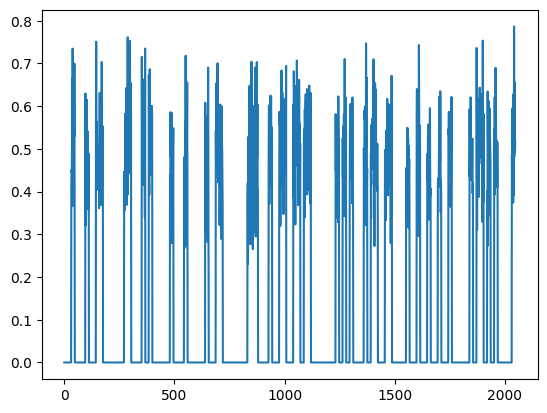

In [21]:
plt.plot(gg)
plt.show()

In [ ]:
del app